In [2]:
import Gen
import Plots
import Random
using Gen, Plots

In [3]:
# struct for shapes 
struct SophieShape
    nvert::Int64
    angles::Vector{Real}
    radii::Vector{Real}
end

In [4]:
# sample shape but there is one vertex per each index assigned a slice of pie in order
@dist lognormal(mu, sigma) = exp(normal(mu, sigma)) 
@gen function sample_shape_sliced()
    angles = Vector{Real}(undef, 6)
    radii = Vector{Real}(undef, 6)
    # limit each vertex to 1/6 of unit circle to prevent  crossovers
    slices = [(0, pi/3), (pi/3, 2*pi/3), (2*pi/3, pi),(pi, 4*pi/3), (4*pi/3, 5*pi/3), (5*pi/3, 2*pi)]
    for i in 1:6
        angles[i] = @trace(uniform(slices[i]...), :angles => i) # uniform within each slice
        radii[i]  = @trace(lognormal(log(3.0), 0.8),   :radii => i) # radii should be positive, params selected by trial/error for desired shapes
    end
    shape = SophieShape(6, angles, radii)
    return shape
end;

In [5]:
#shape = sample_shape_sliced()
#visualize_shape(shape)
#rotated_shape = rotate_shape_about_point(shape, (0.0, 0.0), pi+0.2)
#rotated_shape = rotate_shape_about_point(shape, (0.0, 0.0), pi + 0.2)
#visualize_shape(rotated_shape)
#visualize_shape(shape)

In [6]:
# function to plot a shape
using Plots
function visualize_shape(shape::SophieShape)
    # convert from polar coordinates
    xs = shape.radii .* cos.(shape.angles)
    ys = shape.radii .* sin.(shape.angles)
    xs = [xs; xs[1]]
    ys = [ys; ys[1]]
    plot(xs, ys, legend = false)
end;
# test visualization
#testshape = SophieShape(5, [1.0,2.0, 4.0, 2.4], [1.0,3.0, 1.0, 1.0])
#visualize_shape(testshape)

In [7]:
# functions for rotation
function rotate_point(pointx::Float64, pointy::Float64, centerx::Float64, centery::Float64, angle)
    x = pointx - centerx
    y = pointy - centery
    xprime =  x*cos(angle) - y*sin(angle) + centerx
    yprime =  x*sin(angle) + y*cos(angle) + centery
    return(xprime, yprime)
end;
function polar_to_cart(r::Float64, angle)
     return (r*cos(angle), r*sin(angle))
end;
function cart_to_polar(x::Float64, y)
    return (sqrt(x^2 + y^2), atan(y, x))
end;

function rotate_shape_about_point(shape::SophieShape, point::NTuple{2,Float64}, rotangle)
    # initialize new angles and radii vectors
    angles = Vector{Float64}(undef, shape.nvert)
    radii = Vector{Float64}(undef, shape.nvert)
    # for each vertex
    for i in 1:shape.nvert
        # change to cartesian
        x,y = polar_to_cart(shape.radii[i], shape.angles[i])
        # apply rotation function to point
        xprime, yprime = rotate_point(x, y, point[1], point[2], rotangle)
        # change back to polar
        radius, angle = cart_to_polar(xprime, yprime)
        angle = mod(angle, 2*pi)
        # put angle and radius in vectors
        angles[i] = angle
        radii[i] = radius
    end
    return SophieShape(shape.nvert, angles, radii)

end;

function shape_polar_to_cart(shape::SophieShape)
    x = Vector{Real}(undef, 6)
    y = Vector{Real}(undef, 6)
    for i in 1:6
        (x[i], y[i]) = polar_to_cart(shape.radii[i], shape.angles[i])
    end
    return x, y
end;

In [8]:
# generate data to test
@gen function generate_shape_pair()
    # generate shape
    shape1 ~ sample_shape_sliced()
    # flip a coin to either rotate the shape or generate a new one
    rotate_it ~ bernoulli(0.5)
    if rotate_it == 1
        # random rotation angle
        rotangle ~ uniform(0, 2*pi)
        # random vertex
        # idx ~ uniform_discrete(1,n)
        # point = (shape1.radii[idx], shape1.angles[idx])
        # rotate shape by that angle about chosen vertex
        # or just rotate about origin
        shape2 = rotate_shape_about_point(shape1, (0.0,0.0), rotangle)
    elseif rotate_it == 0
        shape2 ~ sample_shape_sliced()
    end     
    # noisy readings of shapes
    shape1angles = Vector{Float64}(undef, 6)
    shape2angles = Vector{Float64}(undef, 6)
    shape1radii = Vector{Float64}(undef, 6)
    shape2radii = Vector{Float64}(undef, 6)
    for i in 1:6
        shape1angles[i] = @trace(normal(shape1.angles[i], 0.2), :shape1reading => :angles => i)
        shape1radii[i]  = @trace(normal(shape1.radii[i], 0.2),  :shape1reading => :radii => i)
        shape2angles[i] = @trace(normal(shape2.angles[i], 0.2), :shape2reading => :angles => i)
        shape2radii[i]  = @trace(normal(shape2.radii[i], 0.2),  :shape2reading => :radii => i)
    end
    reading1 = SophieShape(6, shape1angles, shape1radii)
    reading2 = SophieShape(6, shape2angles, shape2radii)
    return (reading1, reading2)
end;

In [9]:
# generative function for single noisy shape
@gen function noisy_shape()
    shape ~ sample_shape_sliced()
    # noise
    shapeangles = Vector{Float64}(undef, 6)
    shaperadii = Vector{Float64}(undef, 6)
    for i in 1:6
        shapeangles[i] = @trace(normal(shape.angles[i], 0.1), :observedshape => :angles => i)
        shaperadii[i]  = @trace(normal(shape.radii[i], 0.1),  :observedshape => :radii => i)
    end
    observedshape = SophieShape(6, shapeangles, shaperadii)
    return observedshape
end;

# trace = Gen.simulate(noisy_shape, ())
# choicemap = get_choices(trace)

# make constraints
function make_constraints(observedshape::SophieShape)
    constraints = Gen.choicemap()
    for i=1:observedshape.nvert
        constraints[:observedshape => :radii => i] = observedshape.radii[i]
        constraints[:observedshape => :angles => i] = observedshape.angles[i]
    end
    constraints
end;

In [10]:
# make constraints big model
function make_constraints_two(shape1::SophieShape, shape2::SophieShape)
    constraints = Gen.choicemap()
    for i=1:shape1.nvert
        constraints[:shape1reading => :radii => i] = shape1.radii[i]
        constraints[:shape1reading => :angles => i] = shape1.angles[i]
        constraints[:shape2reading => :radii => i] = shape2.radii[i]
        constraints[:shape2reading => :angles => i] = shape2.angles[i]
    end
    constraints
end;


In [11]:
# visualizing a trace
function visualize_shape_trace(trace::Trace)
    angles = Vector{Float64}(undef, 6)
    radii = Vector{Float64}(undef, 6)
    for i in 1:6
        angles[i] = trace[:shape => :angles => i]
        radii[i] = trace[:shape => :radii => i]
    end
    shape = SophieShape(6, angles, radii)
    visualize_shape(shape)
end
function trace_to_shape(trace::Trace)
    angles = Vector{Float64}(undef, 6)
    radii = Vector{Float64}(undef, 6)
    for i in 1:6
        angles[i] = trace[:shape => :angles => i]
        radii[i] = trace[:shape => :radii => i]
    end
    shape = SophieShape(6, angles, radii)
    return shape
end
function visualize_observed_triangle(trace::Trace)
    angles = Vector{Float64}(undef, 3)
    radii = Vector{Float64}(undef, 3)
    for i in 1:3
        angles[i] = trace[:observedshape => :angles => i]
        radii[i] = trace[:observedshape => :radii => i]
    end
    shape = SophieShape(3, angles, radii)
    visualize_shape(shape)
end;

In [12]:
# MCMC block resim to get posterior for shape 1 angles and radii and shape 2 angles and radii

# Perform a single block resimulation update of a trace.
function block_resimulation_update(tr)
    # Block 1: Update the parameters
    for i in 1:6
    params = select(:shape => :angles => i, :shape => :radii => i)
    (tr, _) = mh(tr, params)
    end
    # angles
    # for i in 1:6
    # params = select(:shape => :angles => i)
    # (tr, _) = mh(tr, params)
    # end
    
    # Return the updated trace
    tr
end;
function block_resimulation_inference(shape::SophieShape)
    observations = make_constraints(shape)
    (tr, _) = generate(noisy_shape, (), observations)
    for iter=1:500
        tr = block_resimulation_update(tr)
    end
    tr
end;


# function map_update(tr)
#     # for i in 1:6
#     # params = select(:shape => :angles => i, :shape => :radii => i)
#     # end
#     params = select(
#         (:shape => :angles => i for i in 1:6)..., 
#         (:shape => :radii => i for i in 1:6)...)
#     initial_score = get_score(tr)
#     println("Start Score: $initial_score")
#     for iter = 1:20
#         # Take a single gradient step on the  parameters.
#         tr = map_optimize(tr, params, max_step_size=0.01, min_step_size=1e-10)  
#         # Check progress
#         new_score = get_score(tr)
#         println("  Iter $iter: $new_score")
#     end
#     tr
# end

# function map_inference(shape::SophieShape)
#     observations = make_constraints(shape)
#     (tr, _) = generate(noisy_shape, (), observations)
#     for iter=1:500
#         tr = map_update(tr)
#     end
#     tr
# end




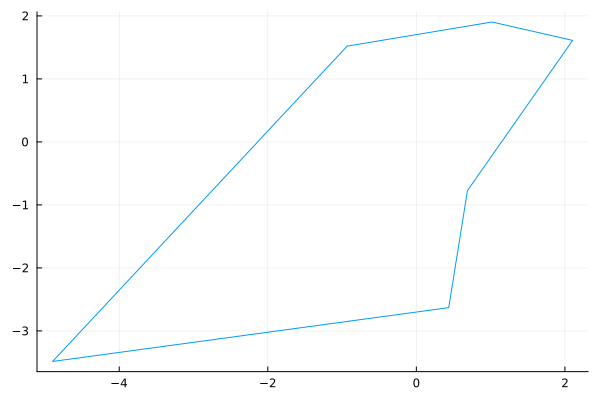

In [13]:
# trace = Gen.simulate(generate_shape_pair, ())
# get_choices(trace)
# tr = block_resimulation_inference(get_retval(trace)[1])
# visualize_shape_trace(tr)

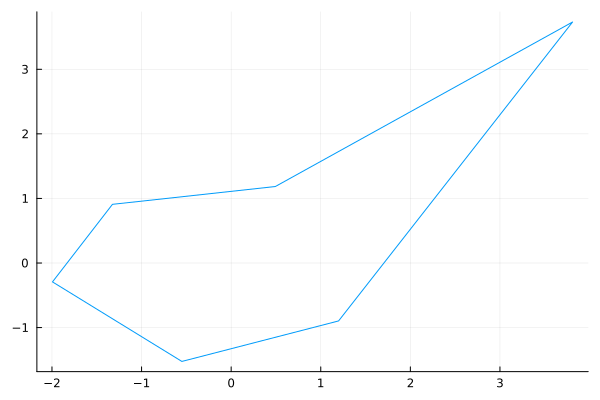

In [14]:
#get_choices(trace)
#shape = 
#visualize_shape(SophieShape(6, [0.7750346588931203, 1.1764116258396995, 2.540397151927358, 3.287278081287021, 4.365944917170996, 5.640834110355242],[5.334208394867754, 1.283290296824267, 1.6066613836024322, 2.0157393392973355, 1.62065700879336, 1.4973638610442244]))

[ Info: Saved animation to /home/psyc2610_sar244/Algorithms-of-the-Mind/labs/tmp.gif


Plots.AnimatedGif("/home/psyc2610_sar244/Algorithms-of-the-Mind/labs/tmp.gif")
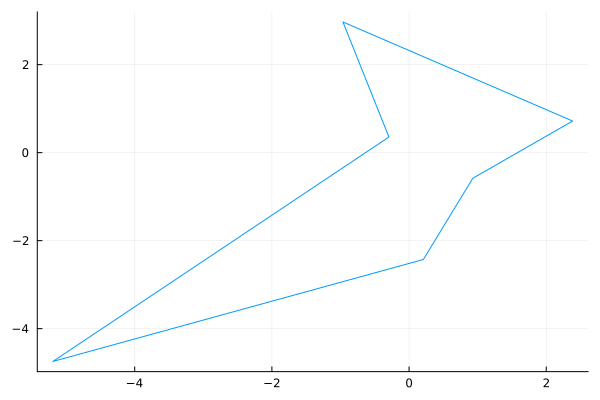

In [15]:
trace = Gen.simulate(generate_shape_pair, ())
observations = make_constraints(get_retval(trace)[1])
t, = generate(noisy_shape, (), observations)

viz = Plots.@animate for i in 1:500
    global t
    t = block_resimulation_update(t)
    visualize_shape_trace(t)
end
gif(viz)

In [17]:
# functions for isolating trianlge
# function that given sophie shape and index returns sophie triangle
function shape_to_triangle(shape::SophieShape, idx::Int64)
    n = shape.nvert
    if idx > 1 && idx < n
        indices = [idx - 1, idx, idx + 1]
    elseif idx == 1
        indices = [n,1,2]
    elseif idx == n
        indices = [n-1, n, 1]
    end
    angles = shape.angles[indices]
    radii = shape.radii[indices]
    return SophieShape(3, angles, radii)
end;

function find_extreme_vertex(shape::SophieShape)
    # say "extreme" is just largest radius
    largest_rad = argmax(shape.radii)
    return largest_rad
end;
    # could also do based on area of triangle...
    # optimizing this could be the key

# generative function that takes sophie shape as input and an index for vertex
@gen function rotate_shape_part(shape::SophieShape, idx::Int64)
    triangle = shape_to_triangle(shape, idx)
    rotangle ~ uniform(0, 2*pi)
    triangle2 = rotate_shape_about_point(triangle, (0.0,0.0), rotangle)
    # noise
    shapeangles = Vector{Float64}(undef, 3)
    shaperadii = Vector{Float64}(undef, 3)
    for i in 1:3
        shapeangles[i] = @trace(normal(triangle2.angles[i], 0.1), :observedshape => :angles => i)
        shaperadii[i]  = @trace(normal(triangle2.radii[i], 0.1),  :observedshape => :radii => i)
    end
    rotatedtriangle = SophieShape(3, shapeangles, shaperadii)
    return rotatedtriangle
end;

# test = SophieShape(3, [pi/7, 2pi/7, 2pi/3], [1,3,1])
# visualize_shape(test)
# trace = Gen.simulate(rotate_shape_part, (test, 2))
# choicemap = get_choices(trace)

In [18]:
@gen function rotangle_proposal(current_trace)
    rotangle ~ normal(current_trace[:rotangle], 0.1)
end;
function block_resimulation_update_triangle(tr)
    # Block 1: Update the parameters
    params = select(:rotangle)
    (tr, _) = mh(tr, params)
    # Return the updated trace
    tr
end;
function gaussian_drift_update_triangle(tr)
    # Block 1: Update the parameters
    (tr, _) = mh(tr, rotangle_proposal, ())
    # Return the updated trace
    return tr
end;

In [19]:
# constrain to other one's sophie triangle
# function part_inference(shape1::SophieShape, shape2::SophieShape)
#     idx1 = find_extreme_vertex(shape1)
#     idx2 = find_extreme_vertex(shape2)
#     triangle2 = shape_to_triangle(shape2, idx2)

#     # constrain 
#     constraints = Gen.choicemap()
#     for i=1:3
#         constraints[:observedshape => :radii => i] = triangle2.radii[i]
#         constraints[:observedshape => :angles => i] = triangle2.angles[i]
#     end
#     (tr, w) = generate(rotate_shape_part, (shape1, idx1), constraints)
#     traces = Vector(undef, 1000)
#     for iter=1:1000
#         tr = gaussian_drift_update_triangle(tr)
#         traces[iter] = tr
#     end

#     # get best inferred rotation angle
#     scores = [get_score(t) for t in traces]
#     best_trace_idx = argmax(scores)
#     best_trace = traces[best_trace_idx]
      
    
#     # look at vertex "opposite" chosen one and see if rotating its triangle works
#     idx1_opp = mod1(idx1 + 3, 6)
#     idx2_opp = mod1(idx2 + 3, 6)
#     triangle2_opp = shape_to_triangle(shape2, idx2_opp)
    
#     # constrain 
#     constraints_opp = Gen.choicemap()
#     constraints_opp[:rotangle] = best_trace[:rotangle] 
#     for i=1:3
#         constraints_opp[:observedshape => :radii => i] = triangle2_opp.radii[i]
#         constraints_opp[:observedshape => :angles => i] = triangle2_opp.angles[i]
#     end
#     (tr_opp, _) = generate(rotate_shape_part, (shape1, idx1_opp), constraints_opp)
#     score = get_score(tr_opp)
#     println("Score on first part: $(get_score(best_trace))")
#     println("Score on second part: $score")
    
#     return score
# end;

# constrain to other one's sophie triangle - improved and returns both scores
function part_inference_2(shape1::SophieShape, shape2::SophieShape)
    idx1 = find_extreme_vertex(shape1)
    idx2 = find_extreme_vertex(shape2)
    triangle2 = shape_to_triangle(shape2, idx2)

    # constrain 
    constraints = Gen.choicemap()
    for i=1:3
        constraints[:observedshape => :radii => i] = triangle2.radii[i]
        constraints[:observedshape => :angles => i] = triangle2.angles[i]
    end
    (tr, w) = generate(rotate_shape_part, (shape1, idx1), constraints)
    traces = Vector(undef, 1000)
    for iter=1:1000
        tr = gaussian_drift_update_triangle(tr)
        traces[iter] = tr
    end

    # get best inferred rotation angle
    scores = [get_score(t) for t in traces]
    best_trace_idx = argmax(scores)
    best_trace = traces[best_trace_idx]
    score_1 = (get_score(best_trace))
      
    
    # look at vertex "opposite" chosen one and see if rotating its triangle works
    idx1_opp = mod1(idx1 + 3, 6)
    idx2_opp = mod1(idx2 + 3, 6)
    triangle2_opp = shape_to_triangle(shape2, idx2_opp)
    
    # constrain 
    constraints_opp = Gen.choicemap()
    constraints_opp[:rotangle] = best_trace[:rotangle] 
    for i=1:3
        constraints_opp[:observedshape => :radii => i] = triangle2_opp.radii[i]
        constraints_opp[:observedshape => :angles => i] = triangle2_opp.angles[i]
    end
    (tr_opp, _) = generate(rotate_shape_part, (shape1, idx1_opp), constraints_opp)
    score_opp = get_score(tr_opp)
    println("Score on first part: $(get_score(best_trace))")
    println("Score on second part: $score_opp")
    
    return score_1, score_opp
end;
    


In [28]:
Random.seed!(140)
testtwin1 = sample_shape_sliced()
testtwin2 = rotate_shape_about_point(testtwin1, (0.0, 0.0), pi)
testunique1 = sample_shape_sliced()
testunique2 = sample_shape_sliced()

SophieShape(6, Real[0.4618142595828499, 1.4074054615085947, 2.3193244974093035, 3.1549204604346524, 4.48919572113353, 5.886371259424756], Real[10.053089212835154, 2.2878048250867824, 1.9274267960045697, 2.7477858681647485, 6.108135049325614, 3.357854433054491])

In [29]:
score = part_inference(testtwin1,testtwin2)

Score on first part: 6.463946068158391
Score on second part: 6.463946068158391
Score on first part: -439.34635290639125
Score on second part: -389.5460994638609


(-439.34635290639125, -389.5460994638609)

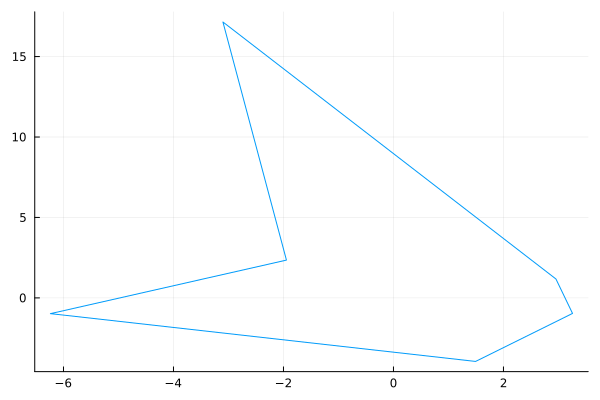

In [30]:
visualize_shape(testtwin1)

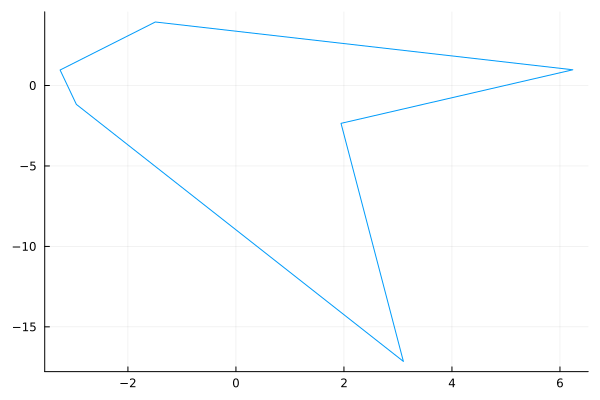

In [31]:
visualize_shape(testtwin2)

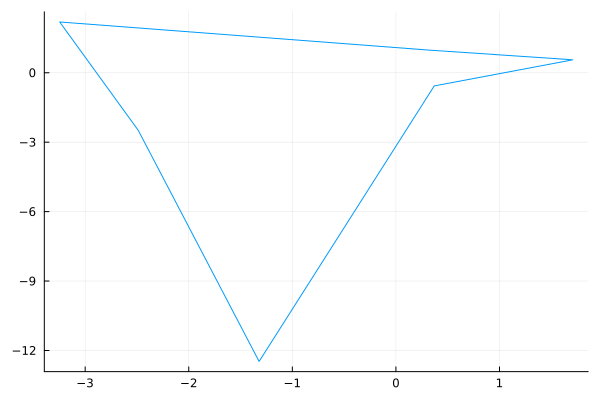

In [32]:
visualize_shape(testunique1)

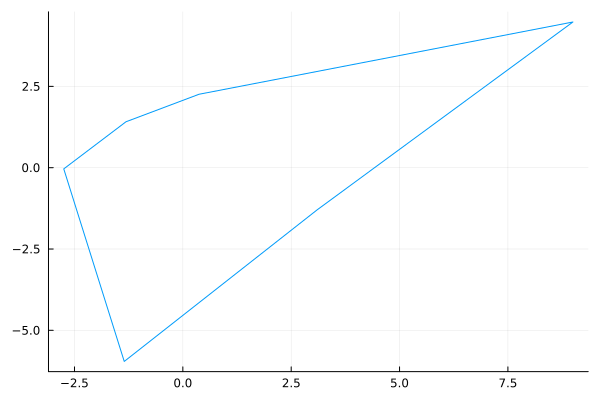

In [33]:
visualize_shape(testunique2)

In [42]:
function solve_task(shape1::SophieShape, shape2::SophieShape)
    # infer shape 1
    trace1 = block_resimulation_inference(shape1)
    shape1 = trace_to_shape(trace1)
    # infer shape 2
    trace2 = block_resimulation_inference(shape1)
    shape2 = trace_to_shape(trace2)
    
    # do part inference
    score, score2 = part_inference_2(shape1, shape2)
    if score > -100 && score2 > 0 
        return 1
    else
        return 0
    end
end;
    # if score greater than cutoff, print "same shape"
    # if score less than cutoff, rpint "different shape"
    

In [35]:
trace = Gen.simulate(generate_shape_pair, ())
test = get_retval(trace)
solve_task(test[1], test[2])

Score on first part: -1288.3479915083758
Score on second part: -1276.0328548587586


0

In [36]:
get_choices(trace)
trace[:rotate_it]

false

In [41]:
# accuracy = Vector(undef, 1000)
# for i in 1:1000
#     trace = Gen.simulate(generate_shape_pair, ())
#     test = get_retval(trace)
#     rotated = solve_task(test[1], test[2])
#     if trace[:rotate_it] == false && rotated == 1 || trace[:rotate_it] == true && rotated == 0
#         accuracy[i] = 0 
#     elseif trace[:rotate_it] == false && rotated == 0 || trace[:rotate_it] == true && rotated == 1
#         accuracy[i] = 1
#     else
#         accuracy[i] = NaN
#     end
# end

# accuracy2 = Vector(undef, 100)
# for i in 1:100
#     trace = Gen.simulate(generate_shape_pair, ())
#     test = get_retval(trace)
#     rotated = solve_task(test[1], test[2])
#     if trace[:rotate_it] == false && rotated == 1
#         accuracy[i] = "true"
#     elseif trace[:rotate_it] == true && rotated == 0
#         accuracy[i] = "false positive"
#     elseif trace[:rotate_it] == false && rotated == 0 || trace[:rotate_it] == true && rotated == 1
#         accuracy[i] = "false negative"
#     else
#         accuracy[i] = "error"
#     end
# end
        

In [37]:
accuracy2 = Vector(undef, 1000)
for i in 1:1000
    trace = Gen.simulate(generate_shape_pair, ())
    test = get_retval(trace)
    rotated = solve_task(test[1], test[2])
    if trace[:rotate_it] == false && rotated == 1
        accuracy2[i] = "false negative"
    elseif trace[:rotate_it] == true && rotated == 0
        accuracy2[i] = "false positive"
    elseif trace[:rotate_it] == false && rotated == 0 || trace[:rotate_it] == true && rotated == 1
        accuracy2[i] = "true"
    else
        accuracy2[i] = "error"
    end
end

Score on first part: -15.08397641211975
Score on second part: 4.446206955440715
Score on first part: 4.285692386642685
Score on second part: 3.903449065787749
Score on first part: -1495.2726376734124
Score on second part: -175.54097463544602
Score on first part: 3.7188025397847295
Score on second part: 3.7946878865582123
Score on first part: -1.1290772406326242
Score on second part: 3.1880313163924567
Score on first part: -1253.0874675203038
Score on second part: -1335.0983200409282
Score on first part: 0.7322249213659178
Score on second part: 1.8256391730340837
Score on first part: -1489.5700890656838
Score on second part: -215.91719972599745
Score on first part: 1.6240314711431179
Score on second part: 3.27485194646981
Score on first part: 2.7960086204805794
Score on second part: 1.3048903470529438
Score on first part: -1401.8323094752939
Score on second part: -221.04232803212622
Score on first part: -1341.3752890455432
Score on second part: -1321.6843206128406
Score on first part: -

In [38]:
sum(accuracy2 .== "false negative")

267

In [39]:
sum(accuracy2 .== "false positive")

211

In [40]:
sum(accuracy2 .== "true")

522